# Radio Recievers and HI Detection

In [145]:
from matplotlib import pyplot as plt
import csv
import numpy as np
from astropy import units as u
import matplotlib
from astropy import constants as apyconst
from IPython.display import Image
matplotlib.rcParams['figure.figsize'] = [10, 6]

# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
#jtplot.style(theme="onedork",grid=False, figsize=[10,6])
#jtplot.reset()
matplotlib.rcParams['figure.figsize'] = [8, 4]
%matplotlib notebook

In [146]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Data Analysis

## Day1 Galactic Test Data 

<IPython.core.display.Javascript object>


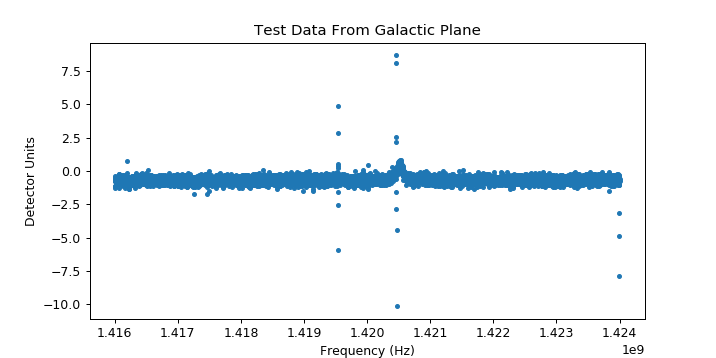

Text(0.5, 1.0, 'Test Data From Galactic Plane')

In [147]:
def get_data(path, clean = True):
    alt = np.loadtxt(path,delimiter=',')
    if clean:
        alt_off = np.loadtxt('day_1/5min_off_altair.csv', delimiter=',')
        alt[::,1] = alt[::,1] - alt_off[::,1]
    return alt

data = get_data('day_1/5min_altair.csv')

plt.figure("data_test")
plt.plot(data[::,0],data[::,1],'.')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Detector Units")
plt.title("Test Data From Galactic Plane")

## Vector Analyzer Data

In [141]:
s = np.loadtxt('vector_analyzer/S.csv',delimiter=',', skiprows=18)
s2 = np.loadtxt('vector_analyzer/S2.csv',delimiter=',',skiprows=18)
bp = np.loadtxt('vector_analyzer/2BP.csv',delimiter=',',skiprows=18)
lbp  = np.loadtxt('vector_analyzer/LBP.csv',delimiter=',',skiprows=18)
sbp  = np.loadtxt('vector_analyzer/SBP.csv',delimiter=',',skiprows=18)

<IPython.core.display.Javascript object>


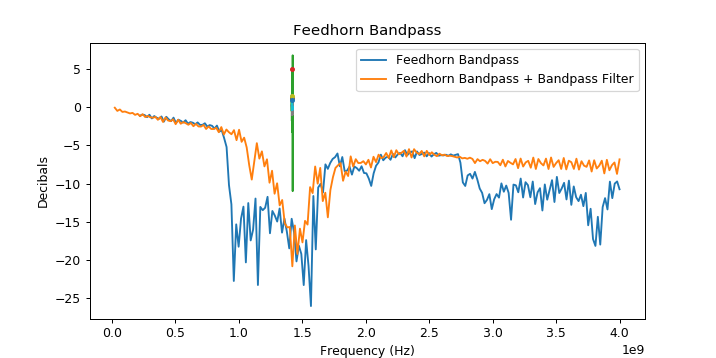

In [148]:
plt.figure("Vector")
plt.plot(s[::,0],s[::,1], label = "Feedhorn Bandpass")
plt.plot(bp[::,0],bp[::,1], label = "Feedhorn Bandpass + Bandpass Filter")
plt.title('Feedhorn Bandpass')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Decibals")
plt.legend()

## Peak Detection Algorithm 

In [149]:
def get_signal(data, filter = False, sigma = 50):
    """This function finds the location of the most prominent peak in a signal
    and performs gaussian filtering of the signal"""
    #Import nvecessary libraries
    from scipy.ndimage import gaussian_filter
    from scipy.signal import find_peaks, peak_prominences
    
    #Check if filtering required
    y = data
    if filter:
        y = gaussian_filter(y,sigma)

    #Get all signal peaks
    peaks, _ = find_peaks(y)

    #Get peak prominances
    proms = peak_prominences(y,peaks)

    #Get the most prominant peak
    peak, _ = find_peaks(y,prominence=np.max(proms[0]))
    
    return y, peak[0]

## Data Import & Visualization Tools

In [150]:
# returns x = frequencies y= signal
def import_data(path,path_baseline = None,remove_base = True):
    """This function imports data from a given path"""
    data = np.loadtxt(path, delimiter=",")
    if remove_base:
        off = np.loadtxt(path_baseline, delimiter=",")
        return data[::,0],data[::,1] - off[::,1]
    return data[::,0], data[::,1]

In [151]:
# Generates a plot of filtered signal
def plot_peak(x,y, sigma = 50, fig_name = ""):
    """Clean plot of imported data for visualization"""
    signal,peak = get_signal(y, filter = True, sigma = sigma)
    #plt.figure(fig_name)
    plt.plot(x,signal)
    plt.plot(x[peak],signal[peak],'.')
    print("Peak Frequency is",x[peak],"Hz") 

### Testing 3-4 

In [152]:
x,y = import_data("day_2/altair.csv","day_2/off.csv",remove_base=True)
plot_peak(x,y, fig_name="t", sigma=0)
plot_peak(x,y, fig_name="t", sigma=50)

Peak Frequency is 1420451972.22841 Hz
Peak Frequency is 1420544136.72067 Hz


In [153]:
x,y = import_data("day_2/deneb.csv","day_2/off.csv",remove_base=True)
x = x[int(len(x)/4):int(len(x)*3/4)]
y = y[int(len(y)/4):int(len(y)*3/4)]

In [154]:
for i in range(12):
    y[np.argmax(y)] = np.mean(y)
    y[np.argmin(y)] = np.mean(y)
plt.plot(x,y)

In [155]:
plot_peak(x,y, fig_name="t", sigma=0)
plot_peak(x,y, fig_name="t", sigma=50)

Peak Frequency is 1420455024.03279 Hz
Peak Frequency is 1420515449.7595 Hz


## Data Analysis 

### Importing Data 

In [156]:
%%bash
# Create files with file names
ls day_1 > ls_d1.txt
ls day_2 > ls_d2.txt
ls sun_1 > ls_s1.txt

In [157]:
# Load files containing file names
day_1_files = np.loadtxt("ls_d1.txt",dtype = str)
day_2_files = np.loadtxt("ls_d2.txt",dtype = str)
sun_files = np.loadtxt("ls_s1.txt",dtype = str)

# Set up dictionaries for data importation
data_1 = {}
data_2 = {}
data_sun = {}

for i in range(len(day_2_files)):
    data_2[day_2_files[i][0:-4].lower()] = np.loadtxt("day_2/"+day_2_files[i], dtype=str, delimiter=',')
    
for i in range(len(day_1_files)):
    data_1[day_1_files[i][0:-4]] = np.loadtxt("day_1/"+day_1_files[i], dtype=str, delimiter=',')
    
for i in range(len(sun_files)):
    data_sun[sun_files[i][0:-4]] = np.loadtxt("sun_1/"+sun_files[i], dtype=str, delimiter=',')

### Location Analysis 

In [158]:
def get_coord(arr):
    from astropy.coordinates import SkyCoord
    
    ra = arr[1] +'h' + arr[2] + 'm' + arr[3] + 's'
    dec = arr[4] +'d' + arr[5] + 'm' + arr[6] + 's'
    coord = SkyCoord(ra,dec)
    
    return coord

In [159]:
locations = {} #astropy coord locations in ra and dec
locg = {} #astropy galactic coords for measurments
for i in range(len(data_2['locations']) -3):
    locations[data_2['locations'][i+1][0].lower()] = get_coord(data_2['locations'][i+1])
    locg[data_2['locations'][i+1][0].lower()] = get_coord(data_2['locations'][i+1]).galactic

In [160]:
c = locations['altair']

In [161]:
locg

{'altair': <SkyCoord (Galactic): (l, b) in deg
     (47.89122852, -9.06350495)>, 'deneb': <SkyCoord (Galactic): (l, b) in deg
     (84.39978882, 1.96044823)>, 'ngc6834': <SkyCoord (Galactic): (l, b) in deg
     (65.83407797, 1.07561318)>, 'ngc6709': <SkyCoord (Galactic): (l, b) in deg
     (42.29422612, 4.49492231)>, 'elephant': <SkyCoord (Galactic): (l, b) in deg
     (99.43009236, 3.74599614)>, 'm52': <SkyCoord (Galactic): (l, b) in deg
     (112.88014753, 0.51437827)>, 'manual': <SkyCoord (Galactic): (l, b) in deg
     (58.93488377, -2.69838403)>, 'off': <SkyCoord (Galactic): (l, b) in deg
     (99.12262559, 36.84134938)>}

### Galactic Plane Data Analysis 

In [162]:
y = data_2[keys[i-1]].astype(float)[::,1] - data_2["off"].astype(float)[::,1]

In [163]:
np.max(y)

5.110099999999996

#### Peak Location Vs Galactic Coords

In [164]:
def get_v(l0,l1):
    return ((l0-l1)/l0)*299792

In [165]:
def get_vt(vlos,l,b):
    return (255*np.sin(l/180*np.pi) + vlos)#*np.cos(b/180*np.pi)

In [166]:
def get_rt(l,b):
        return 8*np.sin(l/180*np.pi)#*np.cos(b/180*np.pi)

597485649.6992073
1419542534.5234 -9.063504946518854 47.89122852255971


<IPython.core.display.Javascript object>


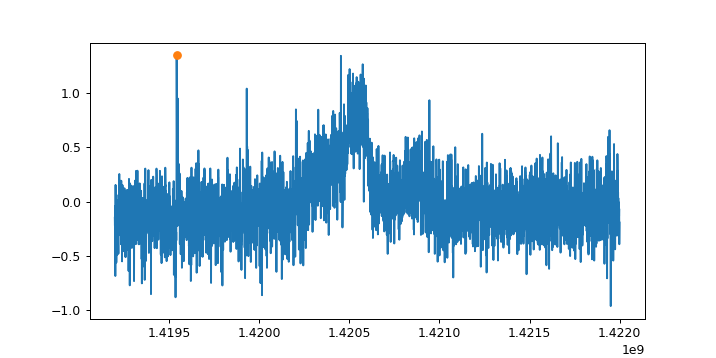

-227082476.07352862
1419933775.84482 1.9604482259709533 84.39978881866963


<IPython.core.display.Javascript object>


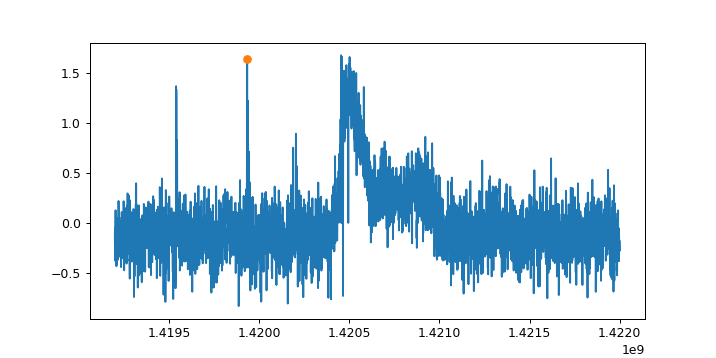

32822616.749479797
1420530708.7814 1.0756131840641714 65.83407797022322


<IPython.core.display.Javascript object>


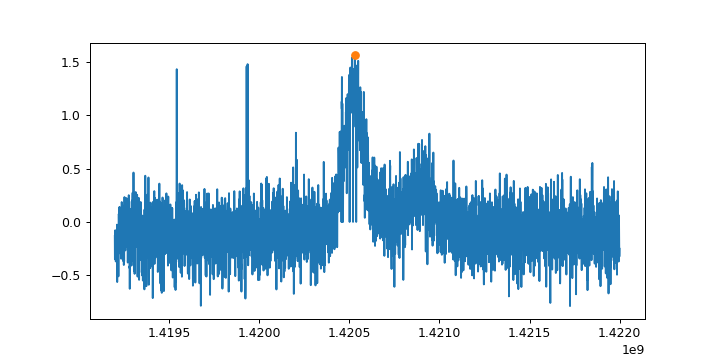

3348828659.1683803
1419772640.5736 4.494922307747855 42.29422612003715


<IPython.core.display.Javascript object>


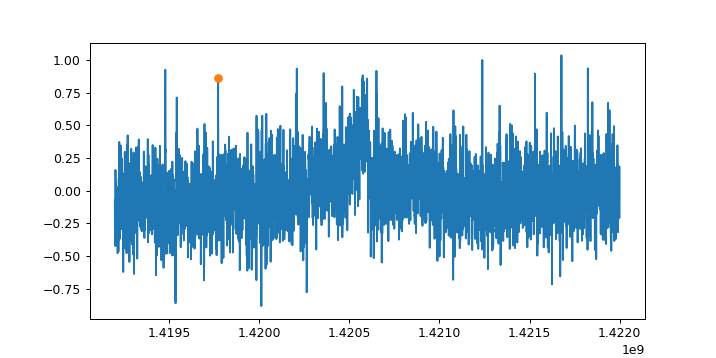

-16577141.451007394
1420459906.9198 3.7459961389665835 99.43009235564668


<IPython.core.display.Javascript object>


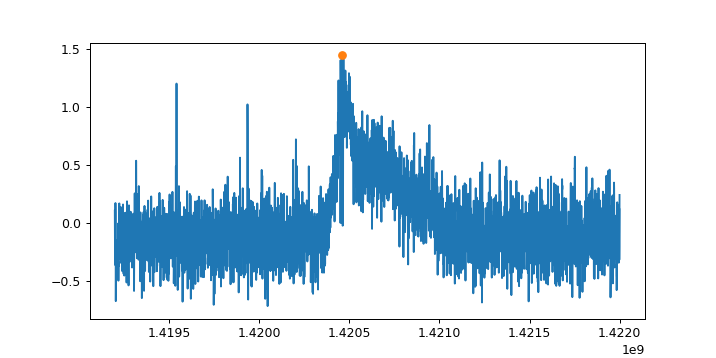

605084903.9400094
1420419623.10199 0.5143782672646873 112.88014752648304


<IPython.core.display.Javascript object>


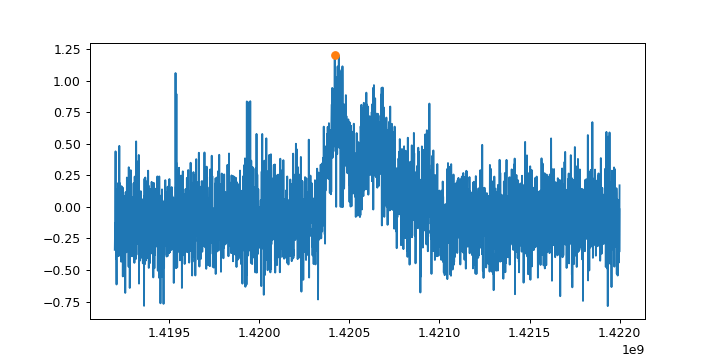

71835378.61668752
1420542305.63804 -2.698384034433615 58.93488377001872


<IPython.core.display.Javascript object>


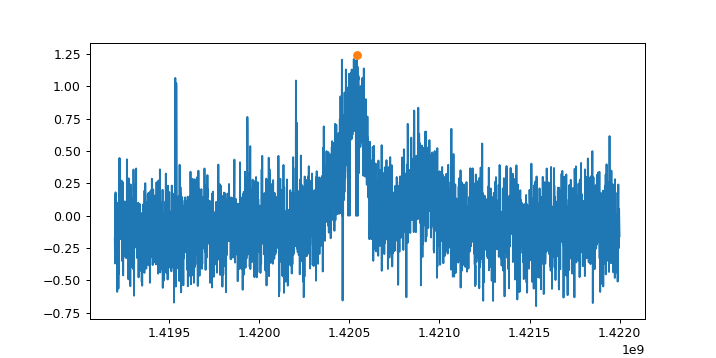

In [212]:
keys = list(locg.keys())
longs = []
lats = []
peaks = []
mults = []

for i in range(1,len(keys)):
    x = data_2[keys[i-1]].astype(float)[::,0]
    y = data_2[keys[i-1]].astype(float)[::,1] - data_2["off"].astype(float)[::,1]
    x = x[int(len(x)/2.5):int(len(x)*3/4)]
    y = y[int(len(y)/2.5):int(len(y)*3/4)]
    mults.insert(i,x*y)
    
    for j in range(12):
        y[np.argmax(y)] = np.mean(y)
        y[np.argmin(y)] = np.mean(y)
    
    signal, peak = get_signal(y-np.mean(y), filter=True,sigma=0)
    long = locg[keys[i-1]].l.deg
    lat = locg[keys[i-1]].b.deg
    
    peaks.insert(i-1, x[peak])
    longs.insert(i-1,long)
    lats.insert(i-1,lat)
    
    print(np.mean(x*y))
    print(x[peak],lat,long)
    plt.figure()
    plt.plot(x,signal)
    plt.plot(x[peak],signal[peak],'o')

In [36]:
vs = []
for i in range(len(peaks)):
    print(get_v(peaks[i],1420455634)*299792)
    vs.insert(i,get_v(peaks[i],1420455634))

7028102.023887772
3282505.420506556
4865733.830987821
8533975.547586063
1583368.972098605
-1313034.4354743042
3861741.7974180807


<IPython.core.display.Javascript object>


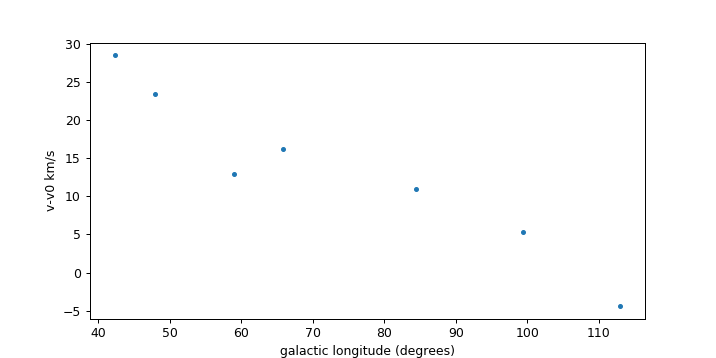

Text(0.5, 0, 'galactic longitude (degrees)')

In [169]:
plt.figure()
plt.clf
plt.plot(longs,vs,'.')
plt.ylabel("v-v0 km/s")
plt.xlabel("galactic longitude (degrees)")

In [39]:
vts = []
rts = []
vv = []
for i in range(len(peaks)):
    if longs[i] < 90:
        vts.insert(i,get_vt(vs[i],longs[i],lats[i]))
        rts.insert(i,get_rt(longs[i],lats[i]))
        vv.insert(i,vs[i])
        
print(vts)

[212.62092569269936, 264.73217151049784, 248.88312612506235, 200.06550545598185, 231.3096633904267]


In [170]:
longs

[47.89122852255971,
 84.39978881866963,
 65.83407797022322,
 42.29422612003715,
 99.43009235564668,
 112.88014752648304,
 58.93488377001872]

<IPython.core.display.Javascript object>


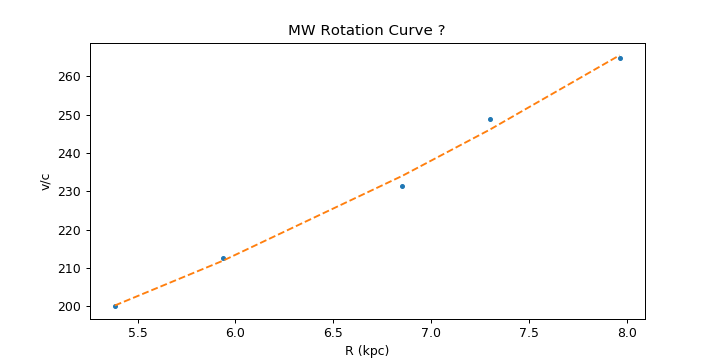

In [174]:
plt.figure()
plt.plot(rts,vts,'.')
plt.xlabel("R (kpc)")
plt.ylabel("v/c")
plt.title("MW Rotation Curve ?");
z = np.polyfit(rts, vts, 2)
p = np.poly1d(z)
plt.plot(np.sort(rts),p(np.sort(rts)),'--')

<IPython.core.display.Javascript object>


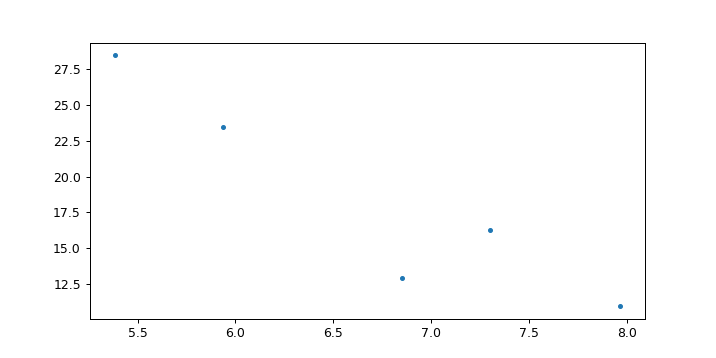

In [173]:
plt.figure()
plt.plot(rts,vv,'.')

### Histogram Method 

## Playground 

<IPython.core.display.Javascript object>


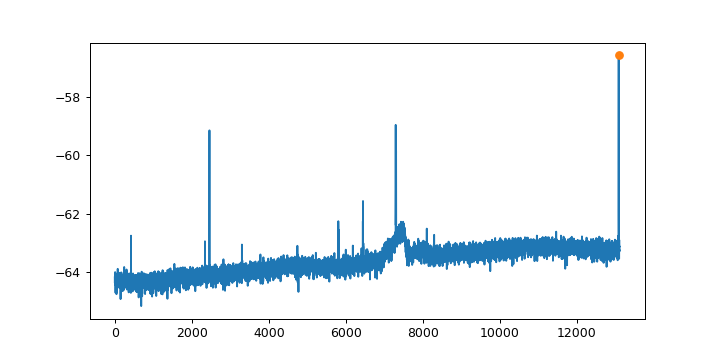

In [175]:
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks, peak_prominences
sun_0 = np.loadtxt("day_2/altair.csv", delimiter=",")
plt.figure("lay")
y = gaussian_filter(sun_0[::,1],0)
#plt.plot(sun_0[::,0],gaussian_filter(sun_0[::,1],1))
peaks, _ = find_peaks(y)
proms = peak_prominences(y,peaks)
peaks, _ = find_peaks(y, prominence= np.max(proms[0]))
plt.plot(y)
plt.plot(peaks,y[peaks], "o")

ValueError: x and y must have same first dimension, but have shapes (6554,) and (13107,)

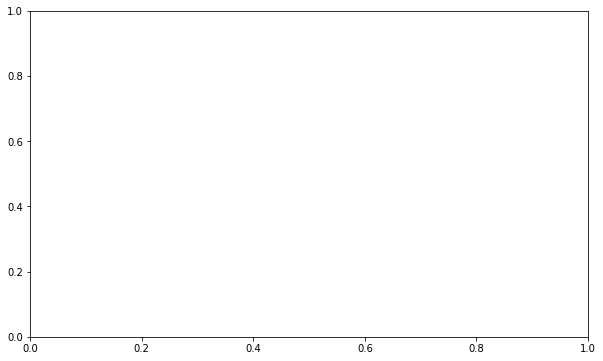

In [44]:
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks, peak_prominences
sun_0 = np.loadtxt("day_2/deneb.csv", delimiter=",")
off = np.loadtxt("day_2/off.csv", delimiter=",")
plt.figure("mu")
x
y = gaussian_filter(sun_0[::,1] - off [::,1],0)
peaks, _ = find_peaks(y)
proms = peak_prominences(y,peaks)
peaks, _ = find_peaks(y, prominence= np.max(proms[0]))
plt.plot(x,y)
plt.plot(peaks,y[peaks], ".")

In [176]:
from scipy import signal

bpass = signal.remez(72, [0, 10, 20, 40, 45, 50], [0, 1, 0])

ValueError: Band edges should be less than 1/2 the sampling frequency

<IPython.core.display.Javascript object>


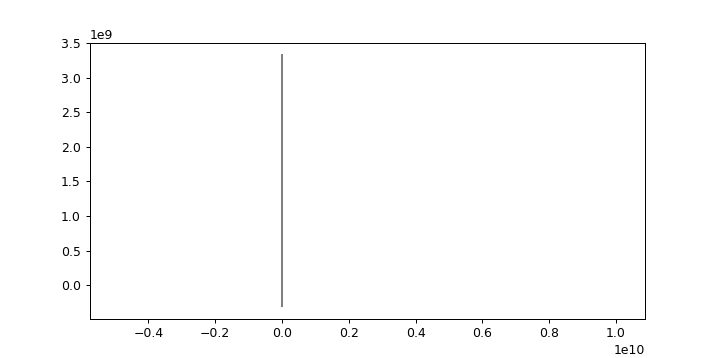

536584001.8593834 439453577.3803667
-298383769.1156304 526323027.67084
-18564003.307680428 489230953.39627093
3321839988.9706697 375188230.0752982
-81749604.03726888 459369997.59771657
551063728.557132 419912076.12345254
26448412.51293058 416100710.36648387


In [202]:
mus = []

from scipy.stats import norm
import matplotlib.mlab as mlab
plt.figure()
for i in range(len(mults)):
    (mu, sigma) = norm.fit(mults[i])
    n, bins, patches = plt.hist(mults[i],1000);
    mus.insert(i,mu)
    print(mu,sigma)

<IPython.core.display.Javascript object>


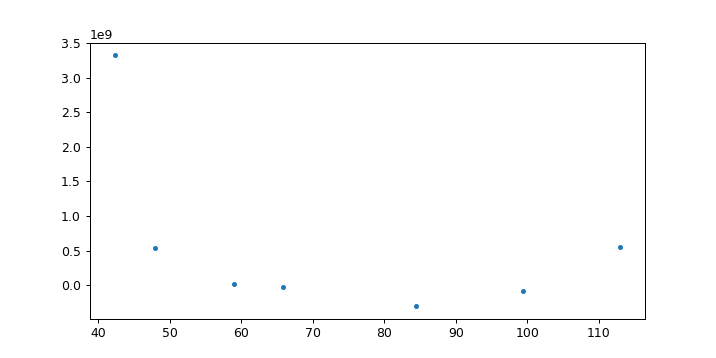

In [207]:
plt.figure()
plt.plot(longs,mus, '.')

# mean

In [177]:
sun_0 = np.loadtxt("sun_1/sun_0.csv", delimiter=",")
sun_1 = np.loadtxt("sun_1/sun_1.csv", delimiter=",")
sun_2 = np.loadtxt("sun_1/sun_2.csv", delimiter=",")
sun_3 = np.loadtxt("sun_1/sun_3.csv", delimiter=",")

<IPython.core.display.Javascript object>


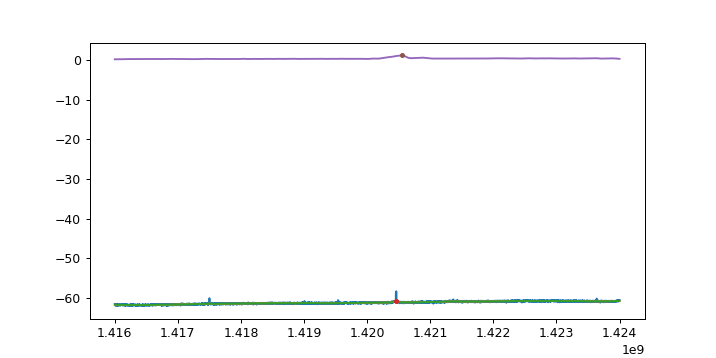

In [178]:
from scipy.ndimage import gaussian_filter
plt.figure()
plt.plot(sun_0[::,0],gaussian_filter(sun_0[::,1],1))
plt.plot(sun_0[::,0],gaussian_filter(sun_0[::,1],50))

In [179]:
plot_peak(sun_0[::,0],sun_0[::,1])

Peak Frequency is 1420455634.39367 Hz


In [180]:
alt =  data_1[list(data_1.keys())[0]] 
alt_off = data_1[list(data_1.keys())[1]] 

In [181]:
x = data_2["altair"].astype(float)[::,0]
y = gaussian_filter(data_2["altair"].astype(float)[::,1] - data_2["off"].astype(float)[::,1],50)
plot_peak(x,y,sigma=0)
plot_peak(alt[::,0],gaussian_filter(alt[::,1]-alt_off[::,1],50))

Peak Frequency is 1420544136.72067 Hz


TypeError: ufunc 'subtract' did not contain a loop with signature matching types dtype('<U16') dtype('<U16') dtype('<U16')

In [182]:
x = data_2["altair"].astype(float)[::,0]
y = gaussian_filter(data_2["altair"].astype(float)[::,1] - data_2["off"].astype(float)[::,1],50)

In [183]:
mult3 = x*y

In [184]:
keys

['altair', 'deneb', 'ngc6834', 'ngc6709', 'elephant', 'm52', 'manual', 'off']

<IPython.core.display.Javascript object>


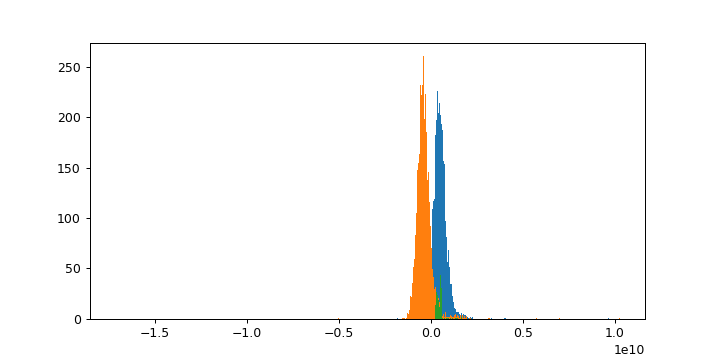

In [185]:
plt.figure()
plt.hist(mult,2000);
plt.hist(mult2,2000);
plt.hist(mult3,2000);

In [71]:
len(y)/2000

6.5535

<IPython.core.display.Javascript object>


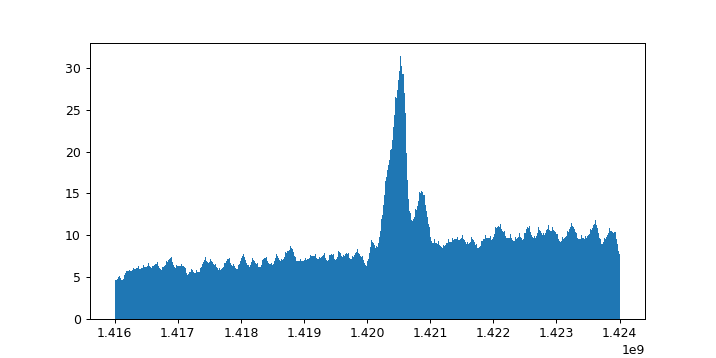

(array([ 4.57362544,  4.5750472 ,  4.79644819,  4.94127913,  5.1354571 ,
         4.82643335,  4.67103874,  4.59961563,  4.72857437,  5.27261337,
         5.48249286,  5.72553557,  5.75389953,  5.68574771,  5.86893414,
         5.67172503,  5.71196309,  5.77449927,  6.09136241,  5.95175889,
         6.00590686,  6.03743257,  6.04734659,  6.25600778,  5.98692677,
         5.98497877,  6.04113249,  6.12146284,  6.40696151,  6.16934715,
         6.1657061 ,  6.21196988,  6.30376577,  6.60672603,  6.30592587,
         6.1697791 ,  6.07808186,  6.35746886,  6.27266326,  6.43102457,
         6.5404734 ,  6.58597642,  6.78839218,  6.35846045,  6.10251696,
         5.90039746,  5.86002731,  6.20844934,  6.16626596,  6.33806385,
         6.475457  ,  6.86694645,  6.78943636,  6.99894125,  7.17976501,
         7.24042387,  7.38114161,  6.79523847,  6.43567005,  6.18532786,
         6.11944715,  6.4196104 ,  6.2598283 ,  6.29178869,  6.28886774,
         6.28564904,  6.55451285,  6.35903662,  6.3

In [187]:
plt.figure()
plt.hist(x,500, weights=y)